In [ ]:
!pip install textract

     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 32.8MB 110kB/s 
     |████████████████████████████████| 5.6MB 45.6MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
     |████████████████████████████████| 112kB 51.6MB/s 
     |████████████████████████████████| 8.9MB 45.8MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 112kB 51.9MB/s 
     |████████████████████████████████| 13.7MB 33.0MB/s 
     |████████████████████████████████| 143kB 51.9MB/s 
  Created wheel for EbookLib: filename=EbookLib-0.17.1-cp36-none-any.whl size=38164 sha256=a0f424d3ce48b290b5b9f1b0333f3ddef4780b69c46a085c16a2eac950ac0e07
  Stored in directory: /root/.cache/pip/wheels/84/11/01/951369cbbf8f96878786a1f4da68bd7ac19a5d945b38e03d54
  Created wheel for python-pptx: filename=python_pptx-0.6.18-cp36-none-any.whl size=275706 sha256=76c019ebef431bf9aa64b647ee

In [ ]:
import textract
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [ ]:
mydirectory='Candidate Resume' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mydirectory, f) for f in os.listdir(mydirectory) if os.path.isfile(os.path.join(mydirectory, f))]

def pdfextract(file):
    text = textract.process(file, method='pdfminer')

    return text

In [ ]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
  
    #below is the csv where we have all the keywords
    keyword_dict = pd.read_csv('template.csv')
    print('The templates on which assessment will be done \n\n\n',keyword_dict.head())
    
    #Creating Directory for individual words
    openness_words = [nlp(text) for text in keyword_dict['openness'].dropna(axis = 0)]             
    neuroticism_words = [nlp(text) for text in keyword_dict['neuroticism'].dropna(axis = 0)]
    conscientiousness_words = [nlp(text) for text in keyword_dict['conscientiousness'].dropna(axis = 0)]
    agreeableness_words = [nlp(text) for text in keyword_dict['agreeableness'].dropna(axis = 0)]
    extraversion_words = [nlp(text) for text in keyword_dict['extraversion']]
       
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Openness', None, *openness_words)
    matcher.add('Neuroticism', None, *neuroticism_words)
    matcher.add('Conscientiousness', None, *conscientiousness_words)
    matcher.add('Agreeableness', None, *agreeableness_words)
    matcher.add('Extraversion', None, *extraversion_words)
    doc = nlp(text)
    
    d = []  
    print(d)
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))
      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

In [ ]:
final_database = pd.DataFrame()

i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1
    
    
#code to count words under each category and visulaize it through Matplotlib
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
print(final_database2)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']

The templates on which assessment will be done 


    openness neuroticism extraversion agreeableness conscientiousness
0    Social     Anxious    Organised       Helpful              Care
1    Honest     Unhappy         Held         Trust           Careful
2  Friendly    Negative         Fest    Empathetic         Closeness
3    Candid    Unstable     Activity      Faithful              Heed
4   Sincere       Worry      Managed   Trustworthy      Meticulosity
[]
Subject       Candidate Name  Agreeableness  Conscientiousness  Openness
0        aditya jain resume               1                  1         1


In [ ]:
final_database2

Subject,Candidate Name,Agreeableness,Conscientiousness,Openness
0,aditya jain resume,1,1,1


In [ ]:
list1=['Openness', 'Neuroticism ', 'Conscientiousness','Agreeableness','Extraversion']

for i in list1:
  if i not in final_database2.columns[1:]:
    final_database2[i]=0

In [ ]:
final_database2

Subject,Candidate Name,Agreeableness,Conscientiousness,Openness,Neuroticism,Extraversion
0,aditya jain resume,1,1,1,0,0


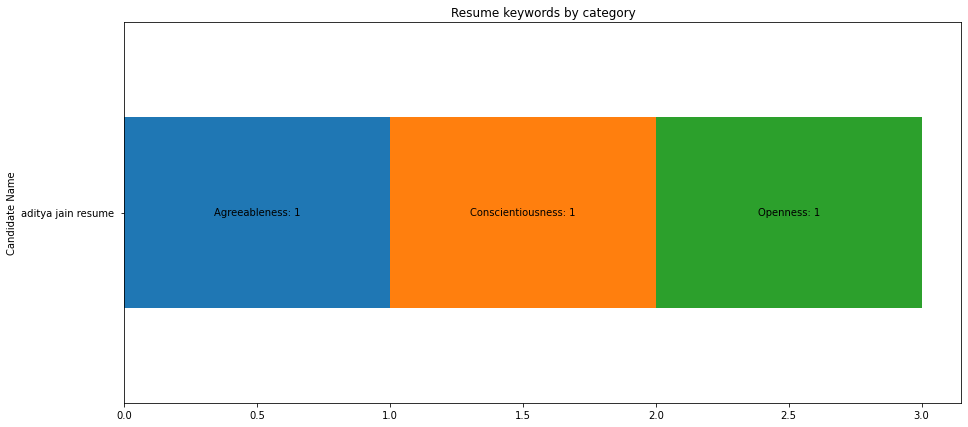

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(15,7), stacked=True)

labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.0, 5.0)

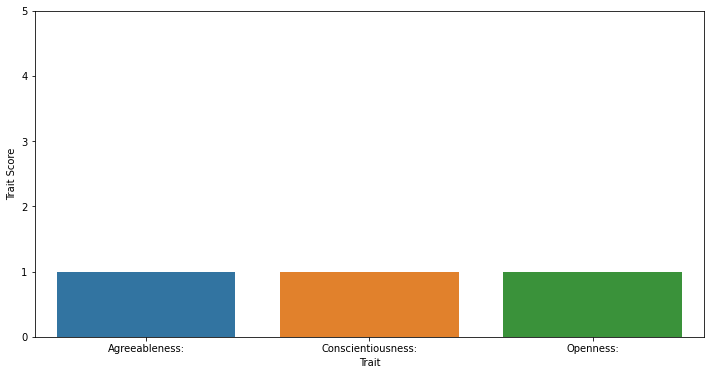

In [ ]:
dic1={}
for i in labels:
   temp1,temp2=i.split(' ')
   temp2=int(temp2)
   dic1[temp1]=temp2

df3=pd.DataFrame(dic1.items(),columns=['Trait','Trait Score'])

import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(x='Trait',y='Trait Score',data=df3)
plt.ylim(0,5)

In [ ]:
import pandas as pd
from numpy import *
import numpy as np
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn import neighbors
from sklearn.naive_bayes import MultinomialNB

In [ ]:
data =pd.read_csv('train dataset.csv').drop(columns = ['Gender', 'Age', ])

x_train = data.drop(columns = ['Personality (Class label)'])
y_train = data['Personality (Class label)']

test =pd.read_csv('test dataset.csv').drop(columns = ['Gender', 'Age', ])

x_test = test.drop(columns = ['Personality (class label)'])
y_test = test['Personality (class label)']
              
data.head()

,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality (Class label)
0,7,4,7,3,2,extraverted
1,4,5,4,6,6,serious
2,7,6,4,5,5,dependable
3,5,6,7,4,3,extraverted
4,7,4,6,5,4,lively


In [ ]:
model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',max_iter =1000)
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(x_test)
model.score(x_test, y_test) 

print('Accuracy score: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy score:  0.6793650793650794
              precision    recall  f1-score   support

  dependable       0.36      0.24      0.29        21
 extraverted       0.64      0.66      0.65        77
      lively       0.68      0.62      0.65        24
 responsible       0.62      0.40      0.48        40
     serious       0.73      0.83      0.78       153

    accuracy                           0.68       315
   macro avg       0.61      0.55      0.57       315
weighted avg       0.67      0.68      0.67       315

[[  5   6   0   1   9]
 [  1  51   4   2  19]
 [  0   4  15   2   3]
 [  2   4   3  16  15]
 [  6  15   0   5 127]]


In [ ]:
##SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_standard_train=scaler.fit_transform(x_train)
x_standard_test=scaler.fit_transform(x_test)
x_train_f=pd.DataFrame(x_standard_train)
x_test_f=pd.DataFrame(x_standard_test)
model = SVC(kernel='linear',gamma=10.0,C=1)
model.fit(x_train_f, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10.0, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_train.value_counts()

serious        161
extraverted    150
dependable     138
lively         134
responsible    126
Name: Personality (Class label), dtype: int64

In [ ]:
y_pred = model.predict(x_test_f)
model.score(x_test_f, y_test)

print('Accuracy score: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy score:  0.6253968253968254
              precision    recall  f1-score   support

  dependable       0.33      0.10      0.15        21
 extraverted       0.58      0.69      0.63        77
      lively       1.00      0.04      0.08        24
 responsible       1.00      0.07      0.14        40
     serious       0.64      0.90      0.75       153

    accuracy                           0.63       315
   macro avg       0.71      0.36      0.35       315
weighted avg       0.68      0.63      0.55       315

[[  2   6   0   0  13]
 [  1  53   0   0  23]
 [  1   6   1   0  16]
 [  1  12   0   3  24]
 [  1  14   0   0 138]]


In [ ]:

final_prediction=model.predict(final_database2.drop(labels=['Candidate Name'], axis=1))



In [ ]:
print('The Nature of the given Candidate based on our model is',''.join(final_prediction))


The Nature of the given Candidate based on our model is dependable


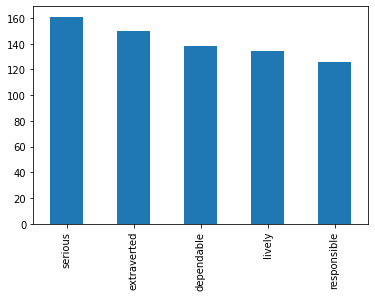

In [ ]:
y_train.value_counts().plot( kind='bar')

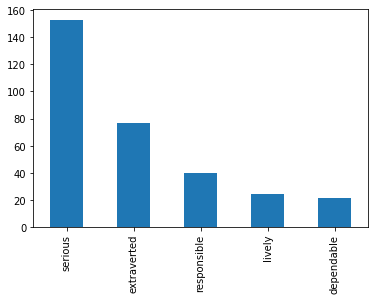

In [ ]:
y_test.value_counts().plot(kind='bar')